# ECE 685D, Fall 2020 
## Problem Set 4


## Full name: Vinayak Gupta


In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import random

### Problem 1: Classification with Convolutional Neural Networks

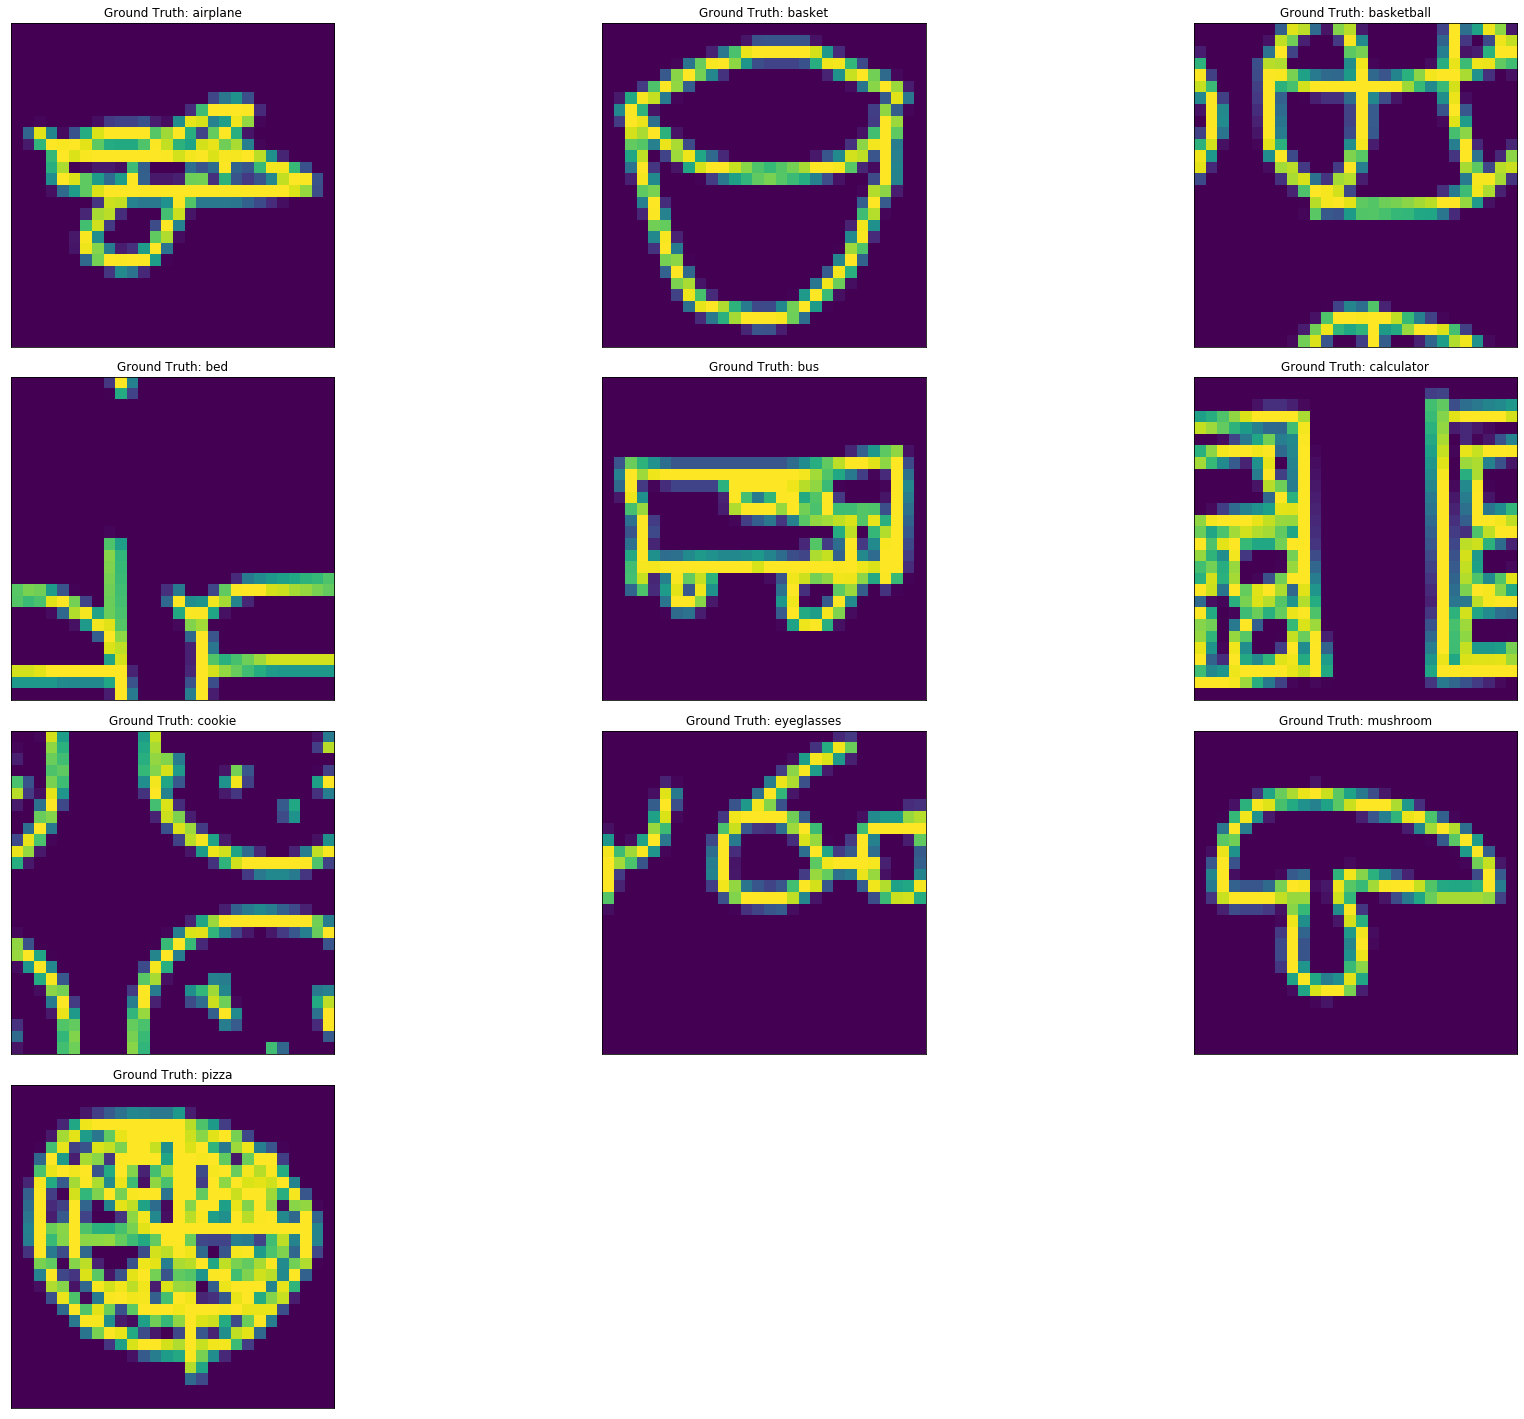

In [2]:
# Preprocessing
labels= ["airplane", "basket", "basketball", "bed", "bus", "calculator", "cookie", "eyeglasses", "mushroom", "pizza"]
X_train = []
y_train = []
X_test = []
y_test = []
idx=0
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(25)
for i in labels:
    plt.subplot(4,3,idx+1)
    plt.tight_layout()
    data = np.load("full_numpy_bitmap_"+i+".npy")
    data = data[np.random.choice(data.shape[0], 7000, replace=False), :]
    X_train.extend(data[:6000])
    X_test.extend(data[6000:])
    y_train.extend([idx]*6000)
    y_test.extend([idx]*1000)
    plt.imshow(np.reshape(data[100],(28,28)), interpolation='none')
    plt.title("Ground Truth: {}".format(i))
    plt.xticks([])
    plt.yticks([])
    idx+=1
plt.show()    
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
X_train = np.reshape(X_train,(X_train.shape[0],1,28,28))
X_test = np.reshape(X_test,(X_test.shape[0],1,28,28))

In [5]:
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(nn.Conv2d(1, 20, kernel_size=5, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 50, 500)
        self.output = nn.Linear(500, 10)
    def forward(self, x):
        x = self.layer(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        out = self.output(x)
        return out

In [7]:
num_epochs = 10 
batch= 1000
accuracy_train=[]
accuracy_test=[]
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

for epoch in range(num_epochs+1)[1:]:
    model.train()
    shuffle = torch.randperm(60000)
    for i in range(0,60000, batch):
        val=shuffle[i:i+batch]
        curr_x, curr_y = X_train[val], y_train[val]
        y_pred_train = model(curr_x)
        loss = criterion(y_pred_train, curr_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.eval()
    y_pred_train = model(X_train)
    correct = (y_pred_train.argmax(1) == y_train)
    accuracy_train.append(torch.sum(correct).item() *100/ len(correct))
    
    y_pred_test = model(X_test)
    correct = (y_pred_test.argmax(1) == y_test)
    accuracy_test.append(torch.sum(correct).item() *100/ len(correct))

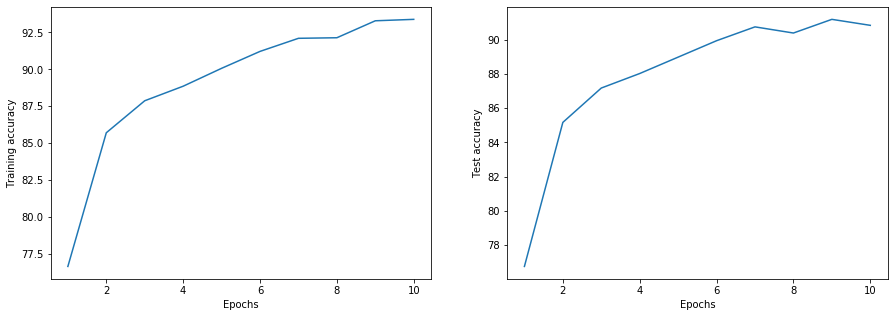

In [8]:
epochs=[i for i in range(1,num_epochs+1)]
# Plot for accuracy
fig= plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
ax1= fig.add_subplot(121)
ax1.plot(epochs,accuracy_train)
ax1.set_xlabel('Epochs', fontsize=10)
ax1.set_ylabel('Training accuracy', fontsize=10)
ax2= fig.add_subplot(122)
ax2.plot(epochs,accuracy_test)
ax2.set_xlabel('Epochs', fontsize=10)
ax2.set_ylabel('Test accuracy', fontsize=10)
plt.show()

**I have used the architecture given in CNN slides, it takes a lot of time to run so just running it for 10 epochs with 1000 as batch size and 0.01 learning rate**

### Problem 2: Feature Extraction Using Autoencoder

In [9]:
# Put your code here 
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms


# Download and prepare the MNIST data set 
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]), download=True)
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))

In [10]:
# Read the training and test data
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=60000, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=True)

dataiter = iter(trainloader)
X_train, y_train = dataiter.next()
X_train=X_train.view(60000,784)

dataiter = iter(testloader)
X_test, y_test = dataiter.next()
X_test=X_test.view(10000,784)

In [11]:
# Accuracy with original features
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
train_accuracy = accuracy_score(y_train,y_pred_train )
print("Training Accuracy:"+str(train_accuracy*100))

y_pred_test = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:"+str(test_accuracy*100))

C:\Users\vinay\Anaconda3\envs\PythonGPU\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training Accuracy:93.62
Test Accuracy:92.5


**AE- based feature extraction**

In [12]:
class AE(torch.nn.Module):
        def __init__(self, input_size, hidden_layers, layer_size, output_size):
            super(AE, self).__init__()
            self.layers = nn.ModuleList()
            self.layers.append(nn.Linear(input_size, layer_size[0]))   
            for i in range(1, hidden_layers):
                self.layers.append(nn.Linear(layer_size[i-1], layer_size[i]))
            self.layers.append(nn.Linear(layer_size[hidden_layers-1], output_size))
                   
            
        def forward(self, x):
            for layer in self.layers[:3]:
                x = F.relu(layer(x))
            x = self.layers[3](x)
            y=x
            for layer in self.layers[4:7]:
                x = F.relu(layer(x))
            output = F.tanh(self.layers[7](x))
            

            return output,y

In [13]:
input_size =784
layer_size = [128,64,12,3,12,64,128]
output_size = 784
hidden_layers = len(layer_size)

In [14]:
model = AE(input_size, hidden_layers, layer_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-2)
num_epochs = 50 
batch= 500
model.train()
#Train the model
for epoch in range(num_epochs):
    shuffle = torch.randperm(60000)
    for i in range(0,60000, batch):
        val=shuffle[i:i+batch]
        curr_x =  X_train[val]
        optimizer.zero_grad()
        output, _ = model(curr_x)
        loss = criterion(output, curr_x)
        loss.backward()
        optimizer.step()

C:\Users\vinay\Anaconda3\envs\PythonGPU\lib\site-packages\torch\nn\functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [15]:
model.eval()
_, enc_train = model(X_train)
_, enc_test = model(X_test)
enc_train = enc_train.float().detach().cpu().numpy()
enc_test = enc_test.detach().cpu().numpy()

In [16]:
#Accuracy with extracted features
clf = LogisticRegression(random_state=42).fit(enc_train, y_train)
y_pred_train = clf.predict(enc_train)
train_accuracy = accuracy_score(y_train,y_pred_train )
print("Training Accuracy:"+str(train_accuracy*100))

y_pred_test = clf.predict(enc_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:"+str(test_accuracy*100))

Training Accuracy:72.23166666666667
Test Accuracy:72.65


C:\Users\vinay\Anaconda3\envs\PythonGPU\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**CAE-based feature extraction**

In [17]:
# New loss function for contractive auto encoder
def losscal(encoder_output,output,curr_x,lamda):
    criterion = nn.MSELoss()
    loss1 = criterion(output, curr_x)
    encoder_output.backward(torch.ones(encoder_output.size()), retain_graph=True)
    loss2 = torch.sum(torch.pow(curr_x.grad,2))
    curr_x.grad.data.zero_()
    return loss1 + lamda*loss2

In [19]:
model = AE(input_size, hidden_layers, layer_size, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-2)
num_epochs = 50 
batch= 500
lamda = 0.1
#Train the model
for epoch in range(num_epochs):
    shuffle = torch.randperm(60000)
    for i in range(0,60000, batch):
        val=shuffle[i:i+batch]
        curr_x =  X_train[val]
        optimizer.zero_grad()
        
        curr_x.requires_grad_(True)
        output, encoder_output = model(curr_x)
      
        
        loss = losscal(encoder_output,output,curr_x,lamda)
        curr_x.requires_grad_(False)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

C:\Users\vinay\Anaconda3\envs\PythonGPU\lib\site-packages\torch\nn\functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [20]:
model.eval()
_, enc_train = model(X_train)
_, enc_test = model(X_test)
enc_train = enc_train.float().detach().cpu().numpy()
enc_test = enc_test.detach().cpu().numpy()

In [21]:
#Accuracy with extracted features
clf = LogisticRegression(random_state=42).fit(enc_train, y_train)
y_pred_train = clf.predict(enc_train)
train_accuracy = accuracy_score(y_train,y_pred_train )
print("Training Accuracy:"+str(train_accuracy*100))

y_pred_test = clf.predict(enc_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:"+str(test_accuracy*100))

Training Accuracy:73.67333333333333
Test Accuracy:74.25


C:\Users\vinay\Anaconda3\envs\PythonGPU\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**PCA-based feature extraction**

In [22]:
from sklearn.decomposition import PCA

In [23]:
pca = PCA(n_components=3).fit(X_train)
reduced_X_train = pca.transform(X_train)
reduced_X_test = pca.transform(X_test)

In [24]:
clf = LogisticRegression(random_state=42).fit(reduced_X_train, y_train)
y_pred_train = clf.predict(reduced_X_train)
train_accuracy = accuracy_score(y_train,y_pred_train )
print("Training Accuracy:"+str(train_accuracy*100))

y_pred_test = clf.predict(reduced_X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:"+str(test_accuracy*100))

Training Accuracy:46.37
Test Accuracy:47.68


C:\Users\vinay\Anaconda3\envs\PythonGPU\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**As we can see, PCA performs the worse (being a linear encoder) whereas AE and CAE perform better. CAE performs better than AE because of regularized loss due to Frobenius norm of the Jacobian**